- 이미지 마스크 추출
    - 주변 픽셀 기반 추출

In [1]:
# https://drive.google.com/file/d/1x_QPmny5fC1kbKUUI4_cVEjsVfqWRGP5/view?usp=drive_link
import gdown
id = '1x_QPmny5fC1kbKUUI4_cVEjsVfqWRGP5'
gdown.download(id=id, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1x_QPmny5fC1kbKUUI4_cVEjsVfqWRGP5
To: /content/open_test.zip
100%|██████████| 15.5M/15.5M [00:00<00:00, 51.6MB/s]


'open_test.zip'

In [2]:
!unzip /content/open_test.zip -d ./open

Archive:  /content/open_test.zip
   creating: ./open/test_input/
  inflating: ./open/test_input/TEST_000.png  
  inflating: ./open/test_input/TEST_001.png  
  inflating: ./open/test_input/TEST_002.png  
  inflating: ./open/test_input/TEST_003.png  
  inflating: ./open/test_input/TEST_004.png  
  inflating: ./open/test_input/TEST_005.png  
  inflating: ./open/test_input/TEST_006.png  
  inflating: ./open/test_input/TEST_007.png  
  inflating: ./open/test_input/TEST_008.png  
  inflating: ./open/test_input/TEST_009.png  
  inflating: ./open/test_input/TEST_010.png  
  inflating: ./open/test_input/TEST_011.png  
  inflating: ./open/test_input/TEST_012.png  
  inflating: ./open/test_input/TEST_013.png  
  inflating: ./open/test_input/TEST_014.png  
  inflating: ./open/test_input/TEST_015.png  
  inflating: ./open/test_input/TEST_016.png  
  inflating: ./open/test_input/TEST_017.png  
  inflating: ./open/test_input/TEST_018.png  
  inflating: ./open/test_input/TEST_019.png  
  inflating: ./

In [3]:
# 상하좌우 픽셀 비교
import numpy as np
from PIL import Image
from collections import deque
from glob import glob
from tqdm import tqdm

# Function to identify contiguous pixels and convert to array
def contiguous_pixels_to_array(img_array):
    visited = np.zeros_like(img_array, dtype=bool)
    arrays = []
    directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]

    def bfs(x, y, val):
        queue = deque([(x, y)])
        current_array = []
        while queue:
            cx, cy = queue.pop()
            if cx < 0 or cx >= img_array.shape[0] or cy < 0 or cy >= img_array.shape[1]:
                continue
            if visited[cx, cy] or img_array[cx, cy] != val:
                continue

            visited[cx, cy] = True
            current_array.append((cx, cy))
            for dx, dy in directions:
                nx, ny = cx + dx, cy + dy
                queue.append((nx, ny))
        return current_array

    for i in range(img_array.shape[0]):
        for j in range(img_array.shape[1]):
            if not visited[i, j]:
                current_array = bfs(i, j, img_array[i, j])
                if len(current_array) > 0:
                    arrays.append(current_array)

    return arrays

# Filter out contiguous regions that are less than 10 pixels long
def filter_large_regions(contiguous_arrays, min_size=750):
    return [region for region in contiguous_arrays if len(region) >= min_size]


In [4]:
# os.chdir("/content")
# !pwd
# !rm -rf masked

In [5]:
# 마스크 위치
!mkdir masked

# 마스크 추출
img_list = sorted(glob('./open/test_input/*.png'))
for Testimage in tqdm(img_list):
# Load image
    img = Image.open(Testimage)
    # 37, 47,

    # Convert image to grayscale
    img_gray = img.convert('L')

    # Convert grayscale image to numpy array
    img_array = np.array(img_gray)

    # Get arrays of contiguous pixels
    contiguous_arrays = contiguous_pixels_to_array(img_array)

    good_regions = filter_large_regions(contiguous_arrays)

    # Create a binary image where contiguous regions of length 10 or more are set to 1
    binary_image = np.zeros_like(img_array, dtype=np.uint8)

    for region in good_regions:
        for x, y in region:
            binary_image[x, y] = 1

    # Convert binary image to a PIL image
    binary_img = Image.fromarray((binary_image * 255).astype(np.uint8))

    # Save the binary image as a PNG file
    binary_img.save(f'./masked/{Testimage.split("/")[-1].split(".")[0]}_mask.png')

100%|██████████| 100/100 [02:58<00:00,  1.79s/it]


- Lama 기반 마스킹 복원
    - 사전학습 모델 그대로 적용

In [6]:
print('\n> Install dependencies')
# !pip install wldhx.yadisk-direct -q
!pip install --upgrade pip -q
!pip uninstall --yes --quiet osqp
!pip install -U scikit-survival -q
!pip uninstall kornia -y
!pip install kornia --no-dependencies -q
!pip install kornia-rs -q
!pip install pytorch-lightning -q
!pip install hydra-core==1.1.1 -q
!pip install webdataset -q
!pip install torch torchvision torchaudio torchtext -q
!pip install wget --quiet
!pip install albumentations==1.3.0 -q


> Install dependencies
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.4/899.4 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 27.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [7]:
!curl -LJO https://huggingface.co/smartywu/big-lama/resolve/main/big-lama.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1169  100  1169    0     0   4911      0 --:--:-- --:--:-- --:--:--  4932
100  363M  100  363M    0     0   161M      0  0:00:02  0:00:02 --:--:--  206M


In [8]:
!unzip /content/big-lama.zip

Archive:  /content/big-lama.zip
  inflating: big-lama/config.yaml    
  inflating: big-lama/models/best.ckpt  


In [9]:
#@title Run this sell to set everything up
print('\n> Cloning the repo')
!git clone https://github.com/advimman/lama.git


> Cloning the repo
Cloning into 'lama'...
remote: Enumerating objects: 469, done.
remote: Counting objects: 100% (269/269), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 469 (delta 148), reused 109 (delta 108), pack-reused 200 (from 1)
Receiving objects: 100% (469/469), 8.83 MiB | 10.83 MiB/s, done.
Resolving deltas: 100% (186/186), done.


In [10]:
print('\n> Init mask-drawing code')
import base64, os
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
from albumentations import DualIAATransform
import matplotlib.pyplot as plt
import numpy as np
import wget
from shutil import copyfile
import shutil
import cv2
from PIL import Image
import numpy as np
from glob import glob


> Init mask-drawing code


In [11]:
!mkdir /content/output

# 단순 이미지 확인용

/content


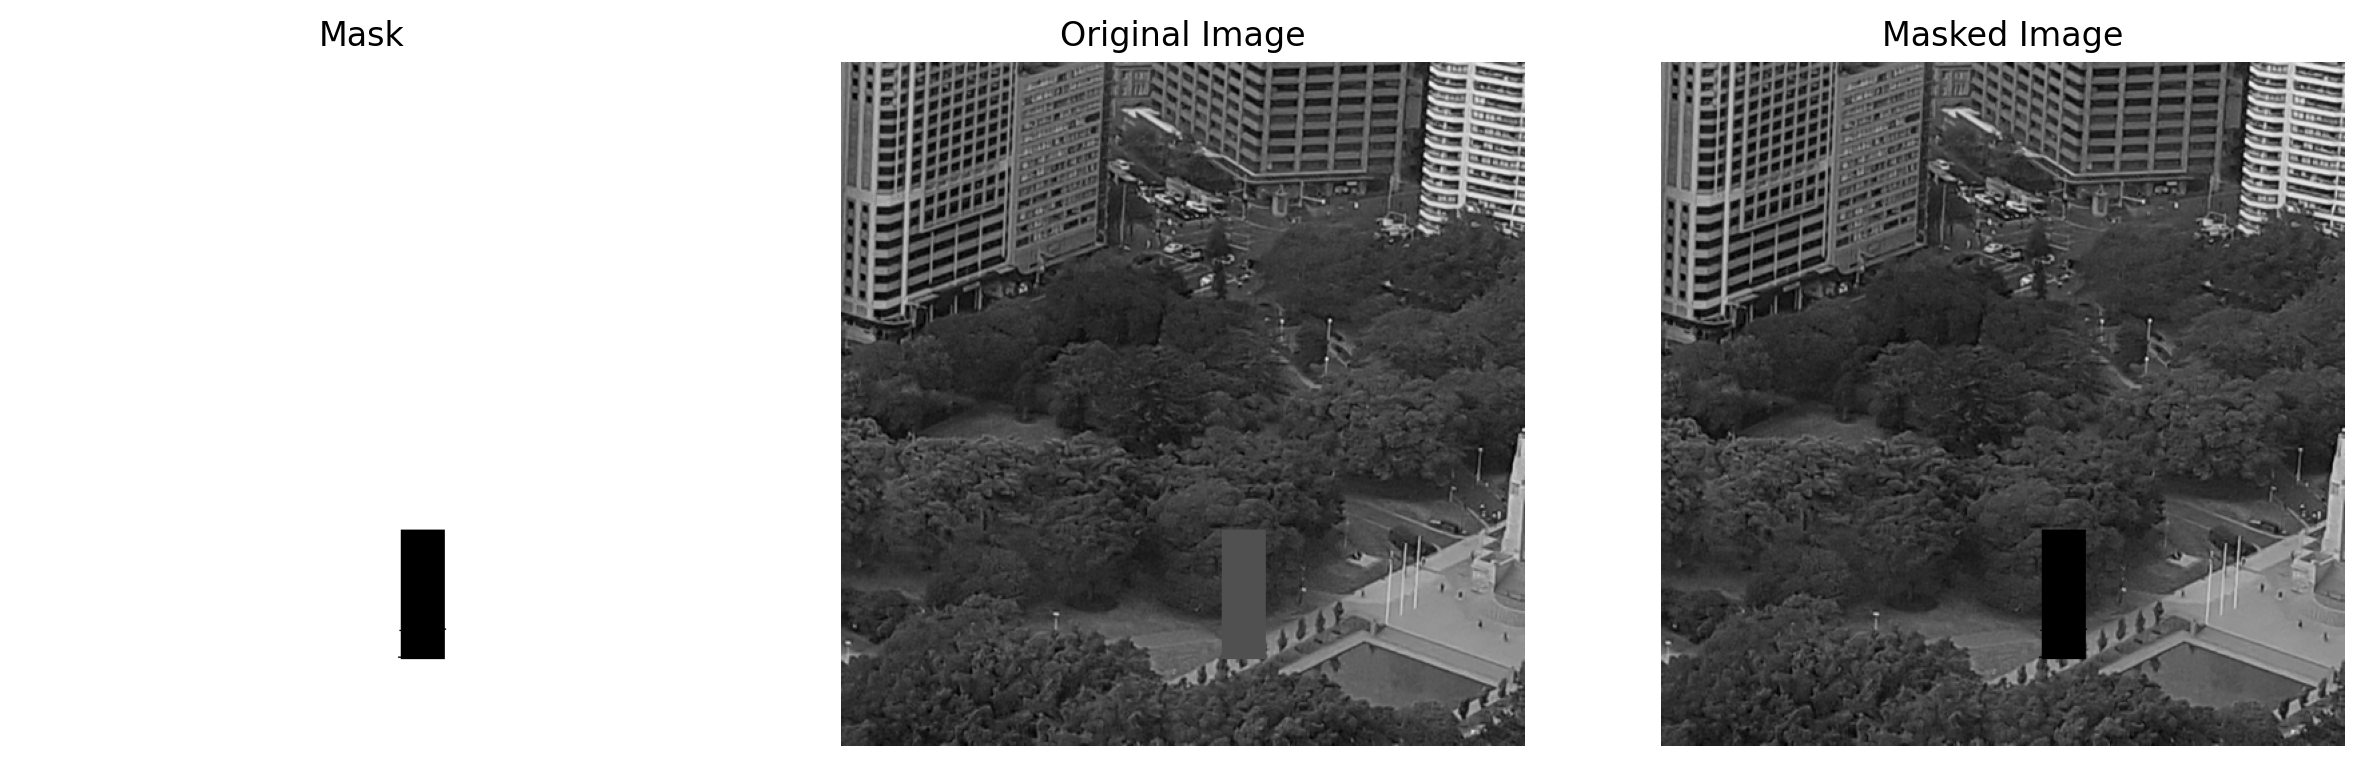

In [12]:
os.chdir("/content")
!PYTHONPATH=. TORCH_HOME=$(pwd)
!pwd

# Load the original image
image_path = '/content/open/test_input/TEST_000.png'  # Replace with your image file path
original_img = Image.open(image_path).convert('RGB')
img_array = np.array(original_img)

# Load the pre-generated mask image (ensure it's binary: 1 for mask, 0 for background)
mask_path = '/content/masked/TEST_000_mask.png'  # Replace with your mask file path
mask_img = Image.open(mask_path).convert('L')
mask_array = np.array(mask_img) < 128  # Assuming your mask is a grayscale image

# Apply the mask to the original image
masked_img_array = img_array * mask_array[:, :, np.newaxis]

# Display results
plt.rcParams["figure.figsize"] = (15, 5)
plt.rcParams['figure.dpi'] = 200

plt.subplot(131)
plt.imshow(mask_array, cmap='gray')
plt.axis('off')
plt.title('Mask')

plt.subplot(132)
plt.imshow(img_array)
plt.axis('off')
plt.title('Original Image')

plt.subplot(133)
plt.imshow(masked_img_array)
plt.axis('off')
plt.title('Masked Image')

plt.show()

os.chdir("/content")


# 마스크 + 이미지 만들기

In [ ]:
import os
from PIL import Image
import numpy as np
import glob
from natsort import natsorted  # 자연스러운 정렬을 위해 natsort 사용
import shutil

# 디렉토리가 존재하면 내부 파일 삭제 후 진행
lama_input_dir = './lama_input'

# 이미지를 저장할 디렉토리 확인 후 생성
lama_input_dir = '/content/lama_input'
if not os.path.exists(lama_input_dir):
    os.makedirs(lama_input_dir)


# 이미지 및 마스크 파일 경로 오름차순 정렬 (숫자 순서 고려)
image_paths = natsorted(glob.glob('/content/open/test_input/*.png'))
mask_paths = natsorted(glob.glob('/content/masked/*.png'))

# 반복문으로 각 이미지에 대해 마스크를 적용
for idx, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):

    # 파일명 추출 및 가공
    f_name = os.path.basename(image_path)  # 경로에서 파일명 추출
    file_name = f_name.split('.')[0]       # 확장자 제거

    # 원본 이미지 로드
    original_img = Image.open(image_path).convert('RGB')
    img_array = np.array(original_img)

    # 미리 생성된 마스크 이미지 로드 (이진 마스크: 마스크는 1, 배경은 0)
    mask_img = Image.open(mask_path).convert('L')
    mask_array = np.array(mask_img) < 128  # 그레이스케일 이미지로 처리

    # 이미지와 마스크를 파일 이름에 맞게 저장
    original_img.save(os.path.join(lama_input_dir, f'{file_name}.png'))  # RGB로 저장
    mask_img.save(os.path.join(lama_input_dir, f'{file_name}_mask.png'))  # 그레이스케일로 저장

    import os
    os.chdir("/content/lama")

    !PYTHONPATH=. TORCH_HOME=$(pwd)
    !pwd

    !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=/content/big-lama indir=/content/lama_input outdir=/content/restored_image dataset.img_suffix=.png > /dev/null



/content/lama
/content/lama/saicinpainting/training/trainers/__init__.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path, map_location=map_location

In [ ]:
import shutil
import os

# 결과가 저장된 디렉토리 경로
output_dir = '/content/restored_image'

# 다운로드할 파일의 경로 (ZIP 파일로 압축)
zip_file_path = '/content/restored_image.zip'

# 폴더를 ZIP 파일로 압축
shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', output_dir)

# 압축된 ZIP 파일 경로 출력
print(f"Download your result from: {zip_file_path}")

# 다운로드 링크 생성
from google.colab import files
files.download(zip_file_path)
